# Multiple Linear Regression for Robot Calibration

In this lab, we will illustrate the use of multiple linear regression for calibrating robot control.  In addition to reviewing the concepts in the [multiple linear regression demo](./glucose.ipynb), you will see how to use multiple linear regression for time series data -- an important concept in dynamical systems such as robotics.

The robot data for the lab is taken generously from the TU Dortmund's [Multiple Link Robot Arms Project](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html).  As part of the project, they have created an excellent public dataset: [MERIt](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt) -- A Multi-Elastic-Link Robot Identification Dataset that can be used for understanding robot dynamics.  The data is from a three link robot:

<img src="http://www.rst.e-technik.tu-dortmund.de/cms/Medienpool/redaktionelleBilder/Forschung/Schwerpunkte/TUDOR_engl/TUDORBild.png" height="200" width="200">


We will focus on predicting the current draw into one of the joints as a function of the robot motion.  Such models are essential in predicting the overall robot power consumption.  Several other models could also be used.

## Load and Visualize the Data
First, import the modules we will need.

In [45]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full MERIt dataset can be obtained from the [MERIt site](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt).  But, this dataset is large.  Included in this repository are two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  We will use the following files:
* [exp1.csv](./exp1.csv) for training
* [exp2.csv](./exp2.csv) for test

Below, I have supplied the column headers in the `names` array.  Use the `pd.read_csv` command to load the data.  Use the `index_col` option to specify that column 0 (the one with time) is the *index* column.  You can review [simple linear regression demo](../simp_lin_reg/auto_mpg.ipynb) for examples of using the `pd.read_csv` command.

In [46]:
names =[
    't',                                  # Time (secs)
    'q1', 'q2', 'q3',                     # Joint angle   (rads)
    'dq1', 'dq2', 'dq3',                  # Joint velocity (rads/sec)
    'I1', 'I2', 'I3',                     # Motor current (A)
    'eps21', 'eps22', 'eps31', 'eps32',   # Strain gauge measurements ($\mu$m /m )
    'ddq1', 'ddq2', 'ddq3'                # Joint accelerations (rad/sec^2)
]
# TODO 
# df = pd.read_csv(...)
df = pd.read_csv("exp1.csv", 
                 header=None,
                 index_col=0,
                 names=names,
                 na_values='?')
    
    
    

Print the first six lines of the pandas dataframe and manually check that they match the first rows of the csv file.

In [47]:
# TODO
df.head(6)

,q1,q2,q3,dq1,dq2,dq3,I1,I2,I3,eps21,eps22,eps31,eps32,ddq1,ddq2,ddq3
t,,,,,,,,,,,,,,,,
0.00,-0.000007,2.4958,-1.1345,-7.882100e-21,-4.940656e-321,3.913100e-29,-0.081623,-0.40812,-0.30609,-269.25,-113.20,3.5918,1.57860,-9.904900e-19,-6.210306e-319,4.917400e-27
0.01,-0.000007,2.4958,-1.1345,-2.258200e-21,-4.940656e-321,2.626200e-31,-0.037411,-0.37241,-0.26698,-270.91,-116.05,1.4585,-1.73980,4.248100e-19,-1.766878e-319,-1.381100e-27
0.02,-0.000007,2.4958,-1.1345,-6.469800e-22,-4.940656e-321,1.762500e-33,-0.066319,-0.40302,-0.31459,-269.25,-112.97,3.5918,0.86753,3.233800e-19,-4.990557e-320,-4.117300e-28
0.03,-0.000007,2.4958,-1.1345,-1.853600e-22,-4.940656e-321,1.182800e-35,-0.068020,-0.43703,-0.28398,-269.97,-114.39,1.6956,-0.08059,1.500500e-19,-1.394253e-320,-1.173100e-28
0.04,-0.000007,2.4958,-1.1345,-5.310600e-23,-4.940656e-321,-5.270900e-03,-0.052715,-0.40472,-0.30779,-269.97,-114.15,3.1177,0.86753,5.932400e-20,-3.581976e-321,-3.770800e-01
0.05,-0.000007,2.4958,-1.1345,-1.521500e-23,-4.940656e-321,3.252600e-04,-0.088425,-0.42342,-0.29589,-269.25,-114.15,2.4066,-0.08059,2.164600e-20,-1.141292e-321,2.930300e-01


From the dataframe `df`, extract the time indices into a vector `t` and extract `I2`, the current into the second joint.  Place the current in a vector `y` and plot `y` vs. `t`.  

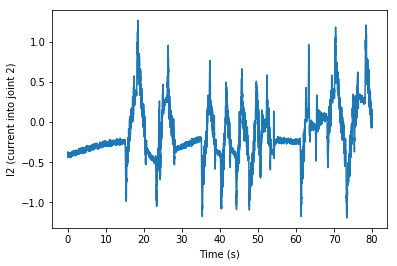

In [48]:
# TODO
# y = ...
# t = ...
# plt.plot(...)

t = np.array(df.index.values)
y = np.array(df["I2"])

plt.plot(t, y)
plt.xlabel("Time (s)")
plt.ylabel("I2 (current into joint 2)")

Use all the samples from the experiment 1 dataset to create the training data:
* `ytrain`:  A vector of all the samples from the `I2` column
* `Xtrain`:  A matrix of the data with the columns:  `['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']`

In [49]:
# TODO
# ytrain = ...
# Xtrain = ...

Xtrain = df.loc[:, ['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']]
ytrain = df["I2"]

## Fit a Linear Model
Use the `sklearn.linear_model` module to create a `LinearRegression` class `regr`.

In [50]:
from sklearn import linear_model

# Create linear regression object
# TODO
# regr = ...

regr = linear_model.LinearRegression()

Train the model on the training data using the `regr.fit(...)` method.

In [51]:
# TODO
regr.fit(Xtrain, ytrain)
print(regr.intercept_)
print(regr.coef_)

-0.0840808377045
[ 0.06255018  0.20584896  0.00118784  0.00044457 -0.0031362   0.00603298
  0.05487097]


Plot the predicted and actual current `I2` over time on the same plot.  Create a legend for the plot.

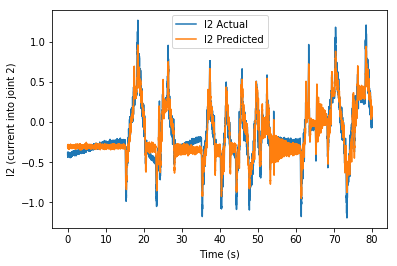

In [63]:
# TODO

y_hat = regr.predict(Xtrain)


actPlt = plt.plot(t, ytrain, label="I2 Actual")
predPlt = plt.plot(t, y_hat, label="I2 Predicted")
plt.legend()

plt.xlabel("Time (s)")
plt.ylabel("I2 (current into joint 2)")



# plt.figure()
# plt.plot(t, (ytrain-y_hat)**2)
# plt.xlabel("Time (s)")
# plt.ylabel("Squared error in I2")

# plt.figure()
# plt.plot(ytrain, y_hat, 'o')
# plt.plot([-1, 1], [-1, 1])   # plot line: actual=predicted
# plt.xlabel("actual")
# plt.ylabel("predicted")



Measure the normalized RSS given by 
$$
    \frac{RSS}{n s^2_y}.
$$

In [66]:
def checkGoodnessofFit(predictor, X, y):
    y_hat = predictor(X)
    RSS = np.sum((y-y_hat) ** 2)
    var_y = np.var(y)
    RSS_norm = RSS /(var_y * y.shape[0])
    y_bar = np.mean(y)
    SStot = np.sum((y-y_bar) ** 2)
    rsq = 1 - RSS / SStot
    return RSS_norm, rsq

RSS_norm, rsq = checkGoodnessofFit(regr.predict, Xtrain, ytrain)

# # TODO
# # RSS_train = ...
# RSS = np.sum((ytrain-y_hat) ** 2)
# # print(RSS)
# var_y = np.var(ytrain)
# # print(np.var(y))

# RSS_norm = RSS /(var_y * ytrain.shape[0])
# # print(RSS_norm)

# y_bar = np.mean(ytrain)
# SStot = np.sum((ytrain-y_bar) ** 2)

# rsq = 1 - RSS / SStot

print("The Normalized RSS (per sample) is "+
          "{:3.4f}.\n{:3.2f}% of the variance is explaned by the model"
          .format(RSS_norm, 100*rsq))



The Normalized RSS (per sample) is 0.0958.
90.42% of the variance is explaned by the model


## Measure the Fit on an Indepdent Dataset

Load the data in `exp2.csv`.  Compute the regression predicted values on this data and plot the predicted and actual values over time.

In [54]:
# TODO
df_test = pd.read_csv("exp2.csv", 
                 header=None,
                 index_col=0,
                 names=names,
                 na_values='?')
    
Xtest = df_test.loc[:, ['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']]
ytest = df_test["I2"]

Measure the normalized RSS on the test data.  Is it substantially higher than the training data?

In [58]:
# TODO

y_hat_test = regr.predict(Xtest)

In [61]:
# TODO
# RSS_train = ...

RSS_test = np.sum((ytest-y_hat_test) ** 2)
# print(RSS)
var_y_test = np.var(ytest)
# print(np.var(y))

RSS_norm_test = RSS_test /(var_y * ytest.shape[0])
# print(RSS_norm)

y_bar_test = np.mean(ytest)
SStot_test = np.sum((ytest-y_bar_test) ** 2)

rsq_test = 1 - RSS_test / SStot_test
# 100*rsq_test

print("The Normalized RSS (per sample) is "+
          "{:3.4f}.\n{:3.2f}% of the variance is explaned by the model"
          .format(RSS_norm_test, 100*rsq_test))




The Normalized RSS (per sample) is 0.0852.
87.32% of the variance is explaned by the model
